![alt text](../figures/header.png "Logo Title Text 1")


# A Deep Dive into Geospatial Analysis

Many of the datasets that data scientists handle have some kind of geospatial component to them, and that information is oftentimes useful-to-critical for understanding the problem at hand. As such, an understanding of spatial data and how to work with it is a valuable skill for any data scientist to have. Even better, Python provides a rich toolset for working in this domain, and recent advances have greatly simplified and consolidated these.

In this tutorial we will take a deep dive into geospatial analysis in Python, using tools like `geopandas`, `shapely`, and `pysal` to analyze a dataset, provided by [Kaggle](https://www.kaggle.com/airbnb-data/boston-airbnb-open-data) (and originally from [Inside AirBnB](http://insideairbnb.com/get-the-data.html)), of sample AirBnB locations in Boston, Massachusetts.

This tutorial is targeted at folks who know a thing or two about data but haven't used Python's geospatial data tools just yet. As such, it assumes a high level of familiarity with `pandas`. Some familiarity with `scikit-learn`, `statsmodels`, `matplotlib`, and `seaborn` is also helpful.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("max_columns", None)

## Plotting Points

First, let's boot up and examine our data. Since our data comes in a simple CSV file, we load it into a `pandas` `DataFrame`.

In [353]:
listings = pd.read_csv("../input/listings.csv")

In [4]:
listings.head()

id                            listing_url       scrape_id  \
0  12147973  https://www.airbnb.com/rooms/12147973  20160906204935   
1   3075044   https://www.airbnb.com/rooms/3075044  20160906204935   
2      6976      https://www.airbnb.com/rooms/6976  20160906204935   
3   1436513   https://www.airbnb.com/rooms/1436513  20160906204935   
4   7651065   https://www.airbnb.com/rooms/7651065  20160906204935   

  last_scraped                                           name  \
0   2016-09-07                     Sunny Bungalow in the City   
1   2016-09-07              Charming room in pet friendly apt   
2   2016-09-07               Mexican Folk Art Haven in Boston   
3   2016-09-07  Spacious Sunny Bedroom Suite in Historic Home   
4   2016-09-07                            Come Home to Boston   

                                             summary  \
0  Cozy, sunny, family home.  Master bedroom high...   
1  Charming and quiet room in a second floor 1910...   
2  Come stay with a friendly, middle-aged guy in ...   
3  Come experience the comforts of home away from...   
4  My comfy, clean and relaxing home is one block...   

                                               space  \
0  The house has an open and cozy feel at the sam...   
1  Small but cozy and quite room with a full size...   
2  Come stay with a friendly, middle-aged guy in ...   
3  Most places you find in Boston are small howev...   
4  Clean, attractive, private room, one block fro...   

                                         description experiences_offered  \
0  Cozy, sunny, family home.  Master bedroom high...                none   
1  Charming and quiet room in a second floor 1910...                none   
2  Come stay with a friendly, middle-aged guy in ...                none   
3  Come experience the comforts of home away from...                none   
4  My comfy, clean and relaxing home is one block...                none   

                               neighborhood_overview  \
0  Roslindale is quiet, convenient and friendly. ...   
1  The room is in Roslindale, a diverse and prima...   
2  The LOCATION: Roslindale is a safe and diverse...   
3  Roslindale is a lovely little neighborhood loc...   
4  I love the proximity to downtown, the neighbor...   

                                               notes  \
0                                                NaN   
1  If you don't have a US cell phone, you can tex...   
2  I am in a scenic part of Boston with a couple ...   
3  Please be mindful of the property as it is old...   
4  I have one roommate who lives on the lower lev...   

                                             transit  \
0  The bus stop is 2 blocks away, and frequent. B...   
1  Plenty of safe street parking. Bus stops a few...   
2  PUBLIC TRANSPORTATION: From the house, quick p...   
3  There are buses that stop right in front of th...   
4  From Logan Airport  and South Station you have...   

                                              access  \
0  You will have access to 2 bedrooms, a living r...   
1  Apt has one more bedroom (which I use) and lar...   
2  I am living in the apartment during your stay,...   
3  The basement has a washer dryer and gym area. ...   
4  You will have access to the front and side por...   

                                         interaction  \
0                                                NaN   
1  If I am at home, I am likely working in my hom...   
2  ABOUT ME: I'm a laid-back, friendly, unmarried...   
3  We do live in the house therefore might be som...   
4  I love my city and really enjoy sharing it wit...   

                                         house_rules  \
0  Clean up and treat the home the way you'd like...   
1  Pet friendly but please confirm with me if the...   
2  I encourage you to use my kitchen, cooking and...   
3  - The bathroom and house are shared so please ...   
4  Please no smoking in the house, porch or on th...   

                                       thumb

In [6]:
len(listings)

3585

At the moment our listings have several geospatial variables, the most important of which are `longitude` and `latitude`, which give the exact coordinates of the BnB in question. This means that it's easy for us to, say, plot every BnB location on a map:

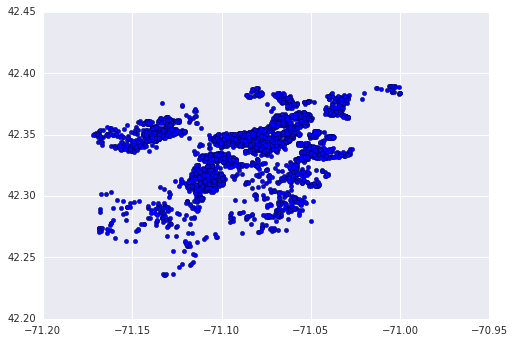

In [525]:
plt.scatter(listings['longitude'], listings['latitude'])

Chances are you've already done this before, and it's a perfectly adequate way to get started working with locations. In this plot we see...not much, really. If you're very intimately familiar with the layout of the city of Boston, you will probably be able to make sense of some of these clusters which are, to me, not being from the city, totally mysterious.

In other words, this plot is missing something important: **geospatial context**.

Additionally, this display is **unprojected**&mdash;it's displayed in terms of raw coordinates. The amount of distance contained in a coordinate degree varies greatly depending on where you are, so this naive plot potentially pretty badly distorts distances.

We'll come back to the projection issue later; for now, there's an easy fix for both these problems.

Enter [`mplleaflet`](https://github.com/jwass/mplleaflet). `mplleaflet` is a tool that automatically takes a coordinate `matplotlib` plot of any kind and places it on top of a [`leaflet`](http://leafletjs.com/) slippy map. The best part is that it's just one additional line of code. Just throw `mplleaflet.display()` after generating your plot to drop it inline in your Jupyter notebook:

In [526]:
import mplleaflet

sample = listings.sample(1000)
plt.scatter(sample['longitude'], sample['latitude'])

mplleaflet.display()

Note, however, that rather than plotting every single point on our map we've taken a sample of 1000 of them and plotted those. This is known as **undersampling**.

This is oftentime necessary, as here, for performance reasons. Because `mplleaflet` embeds point objects directly on an SVG canvas, it's as much as two orders of magnitude slower and more power-hungry than generating a really basic `matplotlib` blob.

There are few ways to get around this limitation. The [`bokeh`](http://bokeh.pydata.org/en/0.11.1/docs/user_guide/geo.html) library is classically mentioned as an option; the new, language-of-graphics-oriented (but still very incomplete) [`geoviews`](https://www.continuum.io/blog/developer-blog/introducing-geoviews) library does an even better job. And if you really, really need to see those points, you can use [`datashader`](http://datashader.readthedocs.io/en/latest/), another not-even-a-year-old visualization library that comfortably works with millions of points ([further reading](https://anaconda.org/jbednar/nyc_taxi/notebook)).

However, in our case we'll do...none of these things. We're not really interested in individaul BnBs, *per se*; we're interested in grouping them and finding similarities and trends amongst them, not what exact street they're on. To do this, we'll wrap these points in polygons of some kind and try to look not at homes, but at neighborhoods.

## Plotting Geometries

The world around us is split up into lots of different kinds of geometries. The big ones are continents; from there we go down to countries, states, districts, counties, and so on.

On the city level, where we are in this case, there are usually a bunch of federal options (PUMAs or electoral districts for example) as well as a variety of usually more targetted geographical aggregations provided by the city government. Usually no matter where you go, however, the lowest-level geometries in the United States are **census tracts**. Census tracts are created every ten years for the census, and are built to try to contain either 4000 or 0 people (in the case of parks, beaches, etc.).

Boston GIS released [data](http://www.arcgis.com/home/item.html?id=5628bfda9466438491219f4d07488a1e) on the census tracts in their city not long after the 2010 census went out, and that's what we'll use.

However, the data comes in the form of a complex and convoluted GIS-standard data format known as a `shapefile` ([further reading](https://en.wikipedia.org/wiki/Shapefile)).

`pandas` has no facilities for reading shapefiles.

When Wes McKinney was first introducing `pandas` to a wider audience, he was asked more than once why he was doing it when everyone was getting along so well passing raw `numpy` arrays back and forth all the time (remember, hindsight is 20/20). Reading shapefiles into Python used to be a similarly terrible experience, until [`geopandas`](http://geopandas.org/) came along and changed everything for the better.

Now you don't need to know anything at all about shapefiles to work with them, you just do this:

In [43]:
import geopandas as gpd

In [8]:
boston = gpd.read_file("../input/Census2010_Tracts.shp")

And you're done!

In [12]:
boston.head()

ALAND10  AWATER10 COUNTYFP10 FUNCSTAT10      GEOID10   INTPTLAT10  \
0  363702.0       0.0        025          S  25025010405  +42.3398654   
1  136829.0       0.0        025          S  25025010404  +42.3419667   
2  127905.0       0.0        025          S  25025010801  +42.3541193   
3  299981.0       0.0        025          S  25025010702  +42.3518354   
4  254706.0       0.0        025          S  25025010204  +42.3462887   

     INTPTLON10 MTFCC10  NAME10           NAMELSAD10 STATEFP10    Shape_Area  \
0  -071.0896052   G5020  104.05  Census Tract 104.05        25  3.914568e+06   
1  -071.0886375   G5020  104.04  Census Tract 104.04        25  1.472714e+06   
2  -071.0770216   G5020  108.01  Census Tract 108.01        25  1.376667e+06   
3  -071.0755159   G5020  107.02  Census Tract 107.02        25  3.228780e+06   
4  -071.1033879   G5020  102.04  Census Tract 102.04        25  2.741497e+06   

     Shape_Leng TRACTCE10                                           geometry  
0  14629.550361    010405  POLYGON ((-71.090087 42.34665699999989, -71.09...  
1   5277.643216    010404  POLYGON ((-71.09065999999994 42.3397659999999,...  
2   6166.497167    010801  POLYGON ((-71.08159499999989 42.35370399999986...  
3   7818.852369    010702  POLYGON ((-71.070655 42.35185399999991, -71.07...  
4   7621.654206    010204  POLYGON ((-71.10682499999994 42.34875299999985...

`geopandas` extends `pandas` `DataFrame` and `Series` expressions into `GeoDataFrame` and `GeoSeries` ones.

The main thing that these add is a `geometry` column containing all of our shapes:

In [9]:
boston['geometry'].head()

0    POLYGON ((766978.240309909 2951616.923866287, ...
1    POLYGON ((766835.3942200691 2949104.969886944,...
2    POLYGON ((769261.2628526837 2954196.132479325,...
3    POLYGON ((772221.7065478563 2953536.652079985,...
4    POLYGON ((762449.9770828187 2952359.446074486,...
Name: geometry, dtype: object

However, these polygons seem more than a little bit weird. The coordinates don't make any sense!

It turns out that the shapefile we're working with is encoded in some kind of alternative **coordinate reference system** (CRS), one with the origin point set to (200000, 750000). We can see this for ourselves by asking our `GeoDataFrame` its `crs` property:

In [10]:
boston.crs

{'datum': 'NAD83',
 'lat_0': 41,
 'lat_1': 41.71666666666667,
 'lat_2': 42.68333333333333,
 'lon_0': -71.5,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'us-ft',
 'x_0': 199999.9999999999,
 'y_0': 750000}

The master directory for all well-known coordinate systems is the **EPSG**. The simple latitude-and-longitude reference system is `epsg:4326`, and `geopandas` makes it really, really easy to "fix" our coordinates by just calling the `to_crs` method:

In [11]:
boston = boston.to_crs({'init': 'epsg:4326'})

In [527]:
boston['geometry'].head()

0    POLYGON ((-71.090087 42.34665699999989, -71.09...
1    POLYGON ((-71.09065999999994 42.3397659999999,...
2    POLYGON ((-71.08159499999989 42.35370399999986...
3    POLYGON ((-71.070655 42.35185399999991, -71.07...
4    POLYGON ((-71.10682499999994 42.34875299999985...
Name: geometry, dtype: object

Much better.

`geopandas` objects have a `plot` method which plops your geometry into a `matplotlib` plot right away:

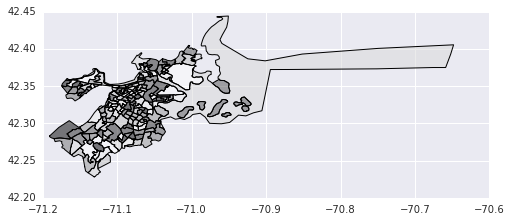

In [528]:
boston.plot()

Again, to get geographic context, let's throw this result at `mplleaflet`!

In [13]:
import mplleaflet

f = plt.figure(figsize=(15, 8))
ax = f.gca()
boston.plot(ax=ax)
mplleaflet.display(fig=f)

There it is&mdash;all the census tracts of the city of Boston.

Notice that some of these tracts have really "weird" shapes. This is because these are census tracts, remember, which try to isolate parts of the city which have people in them from those (like airports, beaches, islands, or the waterway) which do not.

## Upconverting `DataFrame` to `GeoDataFrame` Objects

Under the hood, `geopandas` represents geometries using the [`shapely`](https://github.com/Toblerity/Shapely) library. Just like how when using `pandas` you still occassionally have to reach across to grab something from `numpy`, when working with geometries it's important to understand what `shapely` nets you.

In [14]:
import shapely

Luckily `shapely` has some of the best [documentation](http://toblerity.org/shapely/manual.html) of any library I've ever used, and it's really simple to use.

Recall that our BnB listings was a `DataFrame` containing two geospatial fields, latitude and longitude. As a quick demonstration of `shapely`, let's upconvert this representation to true geometries. To do this we wrap our `DataFrame` in a `GeoDataFrame`, mapping our `geometry` column to a `shapely` `Point` for each coordinate pair.

In [15]:
listings = gpd.GeoDataFrame(listings, geometry=listings.apply(
        lambda srs: shapely.geometry.Point(srs['longitude'], srs['latitude']), axis='columns'
    ))

## Plotting Geometries and Points

We've plotted our points and our polygons seperately, now how do we bring them together?

One obvious answer is to use a `seaborn` [`kdeplot`](http://seaborn.pydata.org/generated/seaborn.kdeplot.html#seaborn.kdeplot), which many of you should be familiar with.

In [88]:
import seaborn as sns

C:\Users\Alex\Anaconda3\envs\geoplot\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


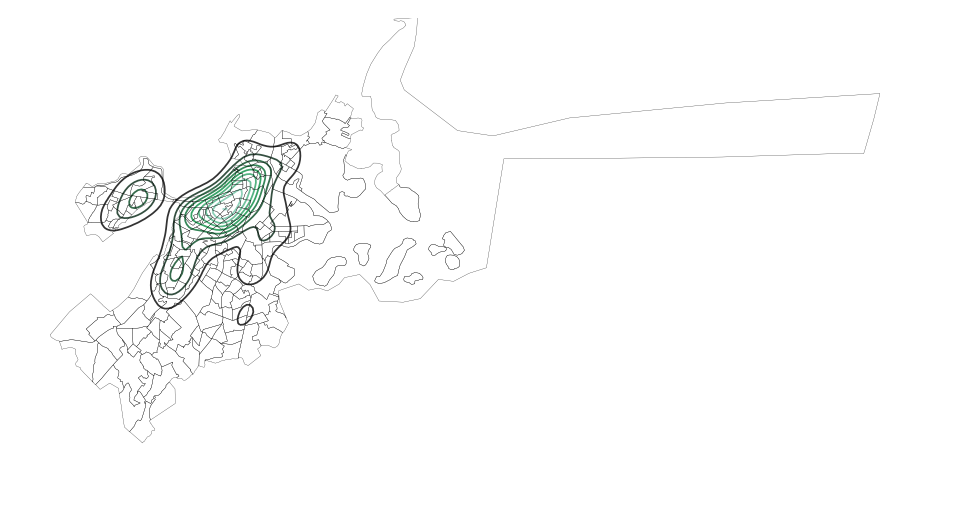

In [120]:
f = plt.figure(figsize=(15, 8))
ax = f.gca()

boston.plot(ax=ax, alpha=0.1, linewidth=0.25, color='white')
sns.kdeplot(data=listings.apply(lambda srs: pd.Series({'x': srs.geometry.x, 'y': srs.geometry.y}), axis='columns'), ax=ax,
            alpha=1)
ax.set_axis_off()

This does give us a good sense of where our AirBNBs are concentrated. Unfortunately, however, KDEs are almost always too "blobish"&mdash;they're not granular enough to show the details inherent in geographic distributions.

With a little bit more work we can get to the closest thing to a gold standard for such things in cartography, a [choropleth map](https://en.wikipedia.org/wiki/Choropleth_map).

First let's create a column in our polygonal dataset, `BNBs`, containing a count of the number of AirBnB locations in the area.

In [16]:
import numpy as np

def assign_census_tract(bnb):
    bools = [geom.contains(bnb['geometry']) for geom in boston['geometry']]
    if True in bools:
        return boston.iloc[bools.index(True)]['NAMELSAD10']
    else:
        return np.nan

In [17]:
listings['census_tract'] = listings.apply(assign_census_tract, axis='columns')

In [18]:
listings['census_tract'].value_counts().head()

Census Tract 701.01    113
Census Tract 102.03    111
Census Tract 8.02       95
Census Tract 201.01     86
Census Tract 606        84
Name: census_tract, dtype: int64

In [19]:
boston['BNBs'] = boston['NAMELSAD10'].map(listings['census_tract'].value_counts())

And now we use that data to throw up a map!

C:\Users\Alex\Anaconda3\envs\geoplot\lib\site-packages\numpy\lib\function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


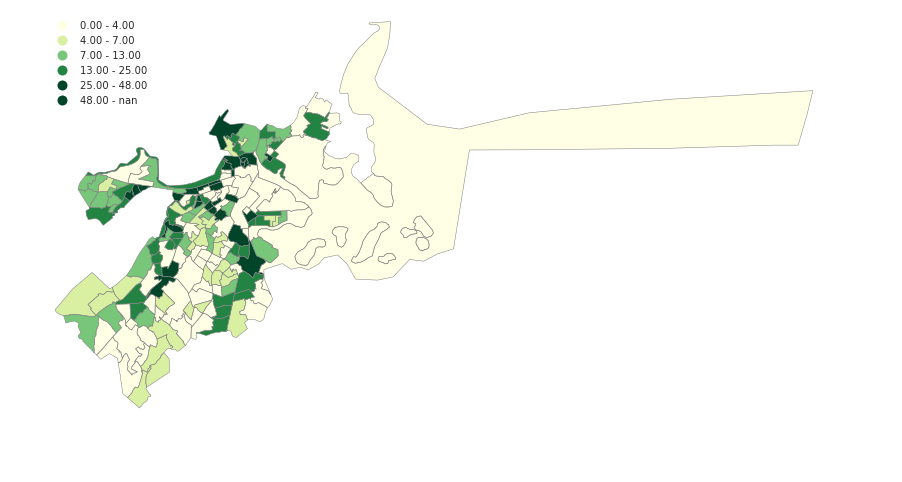

In [154]:
f = plt.figure(figsize=(15, 8))
ax = f.gca()
kw = dict(column='BNBs', k=6, cmap='YlGn', alpha=1, legend=True, edgecolor='gray', linewidth=0.5)
boston.plot(scheme='QUANTILES', ax=ax, **kw)
ax.set_axis_off()

In [182]:
boston['BNBDensity'] = (boston['BNBs'] / boston['geometry']\
                            .to_crs({'init': 'epsg:3857'})\
                            .map(lambda p: p.area / 10**6))\
                            .fillna(0)

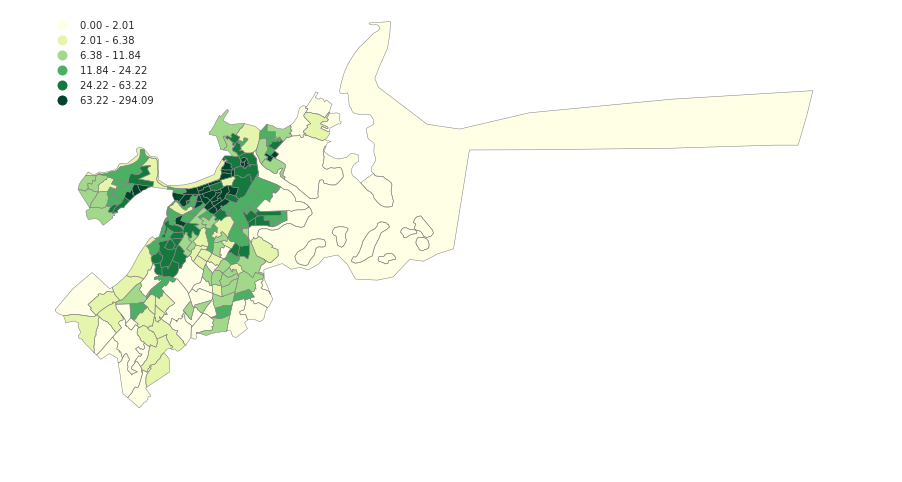

In [184]:
f = plt.figure(figsize=(15, 8))
ax = f.gca()
kw = dict(column='BNBDensity', k=6, cmap='YlGn', alpha=1, legend=True, edgecolor='gray', linewidth=0.5)
boston.plot(scheme='QUANTILES', ax=ax, **kw)
ax.set_axis_off()

In [44]:
import pysal as ps

In [45]:
qW = ps.queen_from_shapefile("../input/Census2010_Tracts.shp")

In [47]:
qW[4]

{6: 1.0, 10: 1.0, 50: 1.0, 80: 1.0}

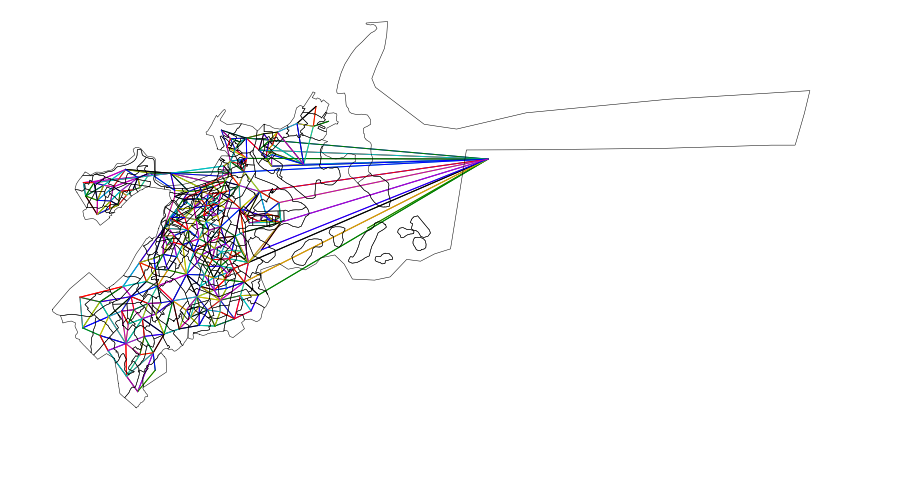

In [70]:
f = plt.figure(figsize=(15, 8))
ax = f.gca()

for i, (k, neighbors) in enumerate(qW.neighbors.items()):
    origin = boston.geometry.iloc[i].centroid
    for nabe_i in neighbors:
        nabe_centroid = boston.geometry.iloc[nabe_i].centroid
        plt.plot([origin.x, nabe_centroid.x], [origin.y, nabe_centroid.y], '-')

boston.plot(ax=ax, linewidth=0.5, facecolor='white')

ax.set_axis_off()

(42.325, 42.375)

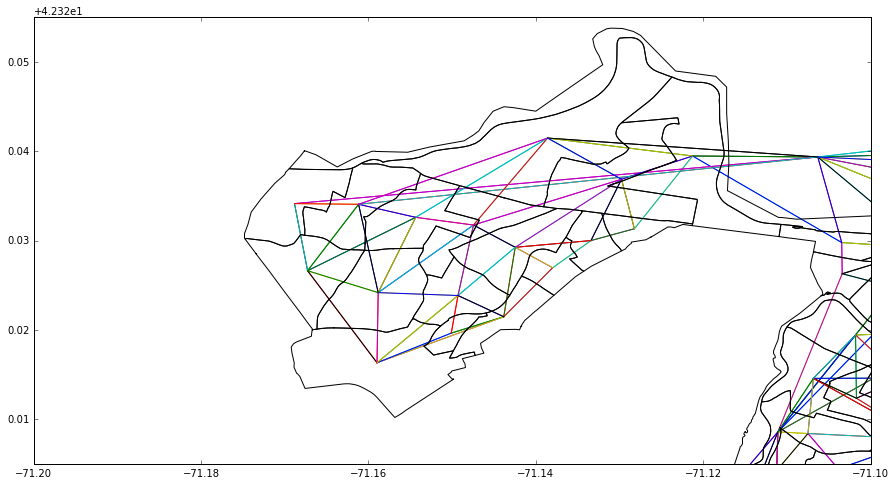

In [76]:
f = plt.figure(figsize=(15, 8))
ax = f.gca()

for i, (k, neighbors) in enumerate(qW.neighbors.items()):
    origin = boston.geometry.iloc[i].centroid
    for nabe_i in neighbors:
        nabe_centroid = boston.geometry.iloc[nabe_i].centroid
        plt.plot([origin.x, nabe_centroid.x], [origin.y, nabe_centroid.y], '-')

boston.plot(ax=ax, linewidth=1, facecolor='white')

ax.set_xlim([-71.2, -71.1])
ax.set_ylim([42.325, 42.375])

In [199]:
bnb_spatial_lags = ps.lag_spatial(qW, boston['BNBDensity'])
spatial_lag_classes = ps.Quantiles(bnb_spatial_lags, k=5)

In [188]:
spatial_lag_classes

                 Quantiles                  
 
 Lower              Upper              Count
           x[i] <=   14.018               19
  14.018 < x[i] <=   24.331               18
  24.331 < x[i] <=   43.946               18
  43.946 < x[i] <=   59.383               18
  59.383 < x[i] <=   85.885               18
  85.885 < x[i] <=  136.440               18
 136.440 < x[i] <=  185.530               17
 185.530 < x[i] <=  280.634               19
 280.634 < x[i] <=  613.336               18
 613.336 < x[i] <= 1128.536               18

In [201]:
spatial_lag_classes.yb

array([4, 4, 4, 4, 3, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 3, 3, 3, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 3,
       3, 2, 4, 4, 4, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 3, 3, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 1, 1, 0, 3, 4, 1, 0, 2, 0, 0, 1, 1, 1, 2, 2, 3,
       3, 2, 1, 0, 4, 3, 1, 3, 2, 2, 3, 4, 4, 3, 1, 3, 4, 0, 0, 0, 2, 0, 0,
       1, 1, 4, 4, 4, 4, 4, 3, 4, 4, 2, 3, 2, 3, 2, 0, 1, 0, 3, 2, 2, 3, 1,
       3, 2, 2, 3, 2, 2, 2, 4, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 1, 2,
       3, 2, 3, 1, 4, 2, 2, 2, 2, 1, 1, 3, 4, 4, 4, 4, 4, 3, 4, 2])

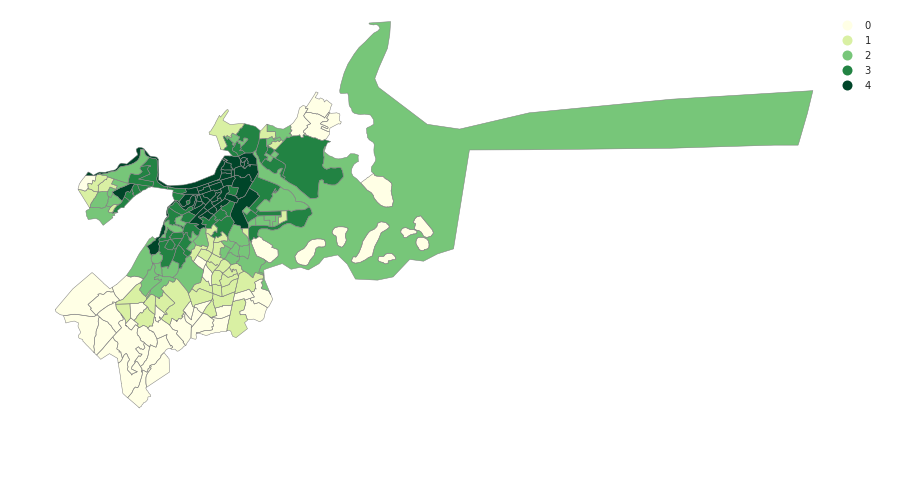

In [200]:
f = plt.figure(figsize=(15, 8))
ax = f.gca()

kw = dict(column='spatial_class', k=5, cmap='YlGn', alpha=1, legend=True, edgecolor='gray', linewidth=0.5, categorical=True)
boston.assign(spatial_class=spatial_lag_classes.yb).plot(ax=ax, **kw)
ax.set_axis_off()

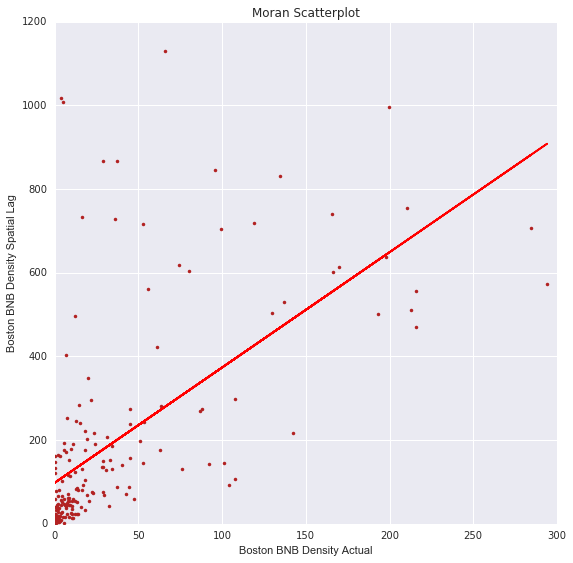

In [218]:
f, ax = plt.subplots(1, figsize=(9, 9))
plt.plot(boston['BNBDensity'], bnb_spatial_lags, '.', color='firebrick')

# Calculate and plot a line of best fit.
b,a = np.polyfit(boston['BNBDensity'], bnb_spatial_lags, 1)
plt.plot(boston['BNBDensity'], a + b*boston['BNBDensity'], 'r')

plt.title('Moran Scatterplot')
plt.ylabel('Boston BNB Density Spatial Lag')
plt.xlabel('Boston BNB Density Actual')
plt.show()

In [214]:
moran = ps.Moran(boston['BNBDensity'].values, qW)
moran.I, moran.p_sim

(0.52791249910953175, 0.001)

### Clustering

In [79]:
listings['property_type'].value_counts()

Apartment          2612
House               562
Condominium         231
Townhouse            54
Bed & Breakfast      41
Loft                 39
Other                17
Boat                 12
Villa                 6
Entire Floor          4
Dorm                  2
Guesthouse            1
Camper/RV             1
Name: property_type, dtype: int64

In [223]:
apartments = listings.query('property_type == "Apartment" or property_type == "Condominium"').groupby('census_tract').count()['id']
houses = listings.query('property_type == "House" or property_type == "Townhouse"').groupby('census_tract').count()['id']

In [259]:
# boston['BNBDensity_Houses'] = boston['Census Tract']
boston['BNBDensity_Houses'] = boston['NAMELSAD10'].map(houses).fillna(0)
boston['BNBDensity_Apartments'] = boston['NAMELSAD10'].map(apartments).fillna(0)

In [260]:
bnb_market = boston[['BNBDensity', 'BNBDensity_Houses', 'BNBDensity_Apartments']]

In [279]:
import sklearn.cluster
import sklearn.preprocessing

clf = sklearn.cluster.KMeans(n_clusters=3)
X = sklearn.preprocessing.scale(bnb_market.values)
classes = clf.fit(X)

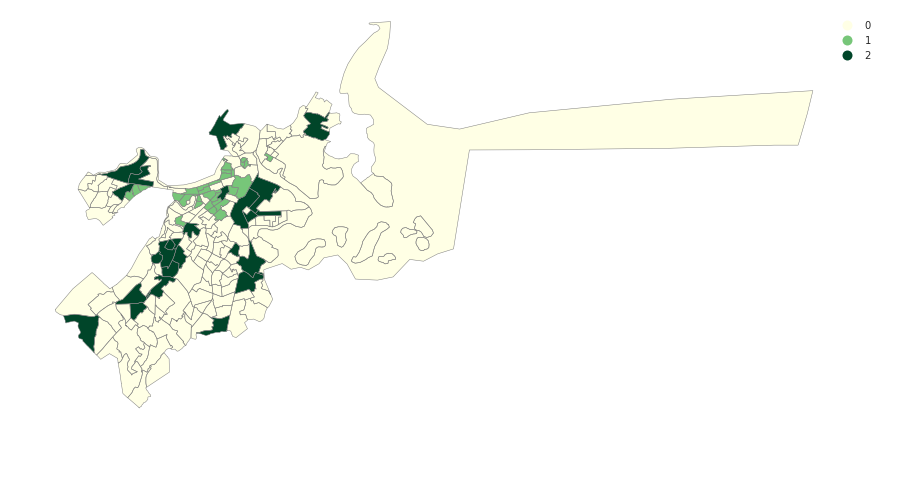

In [280]:
f = plt.figure(figsize=(15, 8))
ax = f.gca()

kw = dict(column='cluster', k=3, cmap='YlGn', alpha=1, legend=True, edgecolor='gray', linewidth=0.5, categorical=True)
boston.assign(cluster=classes.labels_).plot(ax=ax, **kw)
ax.set_axis_off()

In [281]:
bnb_market.assign(cluster=classes.labels_).groupby('cluster').mean()

BNBDensity  BNBDensity_Houses  BNBDensity_Apartments
cluster                                                      
0         12.188742           2.062992               6.740157
1        146.465581           1.724138              46.862069
2         28.905771          11.840000              23.640000

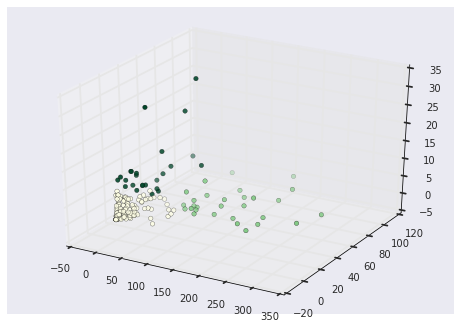

In [282]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(bnb_market['BNBDensity'], bnb_market['BNBDensity_Apartments'],
           zs=bnb_market['BNBDensity_Houses'], c=classes.labels_, cmap='YlGn')

In [328]:
clf = ps.region.Maxp(qW, bnb_market.values, 150, boston['BNBs'].values[:,None])

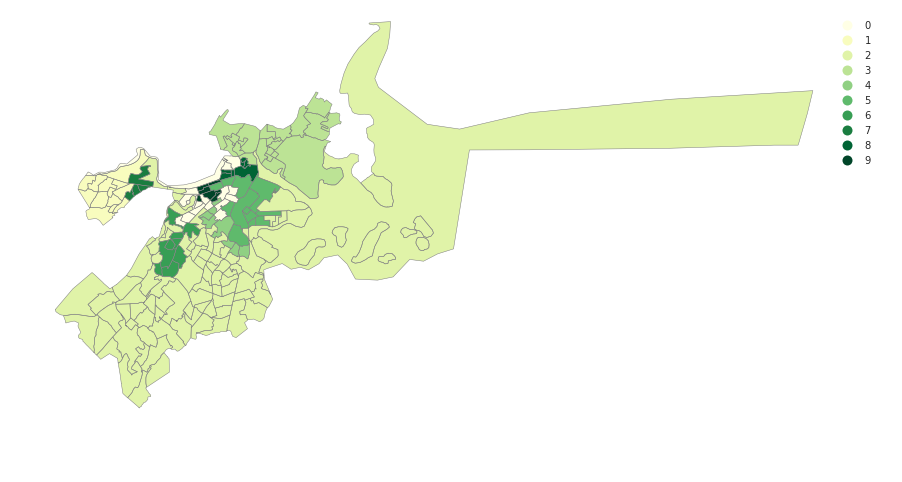

In [331]:
# n = 200
f = plt.figure(figsize=(15, 8))
ax = f.gca()

kw = dict(column='cluster', k=10, cmap='YlGn', alpha=1, legend=True, edgecolor='gray', linewidth=0.5, categorical=True)
boston.assign(cluster=clf.area2region.values()).plot(ax=ax, **kw)
ax.set_axis_off()

In [329]:
bnb_market.assign(cluster=clf.area2region.values()).groupby('cluster').mean()

BNBDensity  BNBDensity_Houses  BNBDensity_Apartments
cluster                                                      
0         78.451566           1.764706              36.647059
1         16.821212           5.833333              11.166667
2          7.442751           2.882353               4.423529
3         21.453374           2.428571              10.142857
4         53.346294           3.375000              15.250000
5         29.089423           3.333333              29.333333
6         39.003481          10.000000              24.777778
7         83.277575          10.500000              39.750000
8        205.586501           1.285714              43.857143
9        166.723335           0.666667              49.500000

### Regression

In [461]:
explanatory_variables = ['bathrooms', 'bedrooms', 'beds', 'guests_included']
price_variables = ['price', 'cleaning_fee']
geom = ['latitude', 'longitude']  # we'll need this later
valid_listings = listings[explanatory_variables + price_variables + geom].dropna()
valid_listings['actual_price'] = valid_listings['price'].map(convert_price) + valid_listings['cleaning_fee'].map(convert_price)
valid_listings = valid_listings.dropna()

def convert_price(price):
    try:
        return float(price.replace("$", "").replace(".", "")[:-2])
    except (ValueError, AttributeError):
        return np.nan

import statsmodels.api as sm
clf = sm.OLS(valid_listings['actual_price'], valid_listings[explanatory_variables])
basic_ols_res = clf.fit()

In [462]:
basic_ols_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           actual_price   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     2808.
Date:                Sun, 20 Nov 2016   Prob (F-statistic):               0.00
Time:                        19:55:02   Log-Likelihood:                -15293.
No. Observations:                2460   AIC:                         3.059e+04
Df Residuals:                    2456   BIC:                         3.062e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
bathrooms          86.6214      4.185     20.699      0.000        78.415    94.828
bedrooms           38.2459      4.722      8.099      0.000        28.986    47.505
beds               36.4452      3.642     10.006      0.000        29.303    43.588
guests_included    12.0422      2.316      5.199      0.000         7.500    16.585
==============================================================================
Omnibus:                      172.427   Durbin-Watson:                   1.296
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              241.583
Skew:                           0.592   Prob(JB):                     3.48e-53
Kurtosis:                       3.977   Cond. No.                         7.49
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [464]:
valid_listings[['longitude', 'latitude']].values

array([[-71.13306793,  42.2826188 ],
       [-71.13437396,  42.28624082],
       [-71.12102117,  42.28110619],
       ..., 
       [-71.12286847,  42.34937989],
       [-71.11833554,  42.34750341],
       [-71.08065372,  42.38788781]])

In [513]:
w = ps.knnW_from_array(valid_listings[['longitude', 'latitude']].dropna().values, k=2)
# w.transform = 'R'
w

In [514]:
geospatial_ols = ps.spreg.GM_Lag(valid_listings['actual_price'].values[:, None],
                                 valid_listings[explanatory_variables].values,
                                 w=w,
                                 name_x=explanatory_variables,
                                 name_y='actual_price')

In [515]:
print(geospatial_ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :actual_price                Number of Observations:        2460
Mean dependent var  :    246.6793                Number of Variables   :           6
S.D. dependent var  :    145.2765                Degrees of Freedom    :        2454
Pseudo R-squared    :      0.2996
Spatial Pseudo R-squared:  0.3265

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      74.5257846      11.4683038       6.4984139       0.0000000
           bathrooms      48.5721848       6.0617495       8.0128988       0.0000000
            bedrooms      39.4847512       4.7342175       

In [524]:
geospatial_ols_mse = ((valid_listings['actual_price'] - geospatial_ols.predy.flatten()) ** 2).mean()
print("OLS".ljust(5), ":", basic_ols_res.mse_total)
print("OLS+W".ljust(5), ":", geospatial_ols_mse)

OLS   : 81947.352439
OLS+W : 14788.3873299


In [516]:
geospatial_ols_mse

14788.387329874136

In [517]:
basic_ols_res.mse_total

81947.352439024384

### Bonus maybe?

In [376]:
amenities = listings['amenities'].map(lambda d: [amenity.replace('"', "")\
                                                        .replace("{", "")\
                                                        .replace("}", "") for amenity in d.split(",")])
listings['amenities'] = amenities

In [372]:
possible_amenities = set([item for sublist in amenities for item in sublist])

In [373]:
possible_amenities

{'',
 '24-Hour Check-in',
 'Air Conditioning',
 'Breakfast',
 'Buzzer/Wireless Intercom',
 'Cable TV',
 'Carbon Monoxide Detector',
 'Cat(s)',
 'Dog(s)',
 'Doorman',
 'Dryer',
 'Elevator in Building',
 'Essentials',
 'Family/Kid Friendly',
 'Fire Extinguisher',
 'First Aid Kit',
 'Free Parking on Premises',
 'Free Parking on Street',
 'Gym',
 'Hair Dryer',
 'Hangers',
 'Heating',
 'Hot Tub',
 'Indoor Fireplace',
 'Internet',
 'Iron',
 'Kitchen',
 'Laptop Friendly Workspace',
 'Lock on Bedroom Door',
 'Other pet(s)',
 'Paid Parking Off Premises',
 'Pets Allowed',
 'Pets live on this property',
 'Pool',
 'Safety Card',
 'Shampoo',
 'Smoke Detector',
 'Smoking Allowed',
 'Suitable for Events',
 'TV',
 'Washer',
 'Washer / Dryer',
 'Wheelchair Accessible',
 'Wireless Internet',
 'translation missing: en.hosting_amenity_49',
 'translation missing: en.hosting_amenity_50'}